In this notebook I performed a preliminary exploration on the Alibaba dataset. In particular the dataset is https://github.com/alibaba/clusterdata/tree/master/cluster-trace-microservices-v2021 and I look at one part of the MSCallGraph table.

I found 7386 unique microservices IDs that I guess can be used as nodes.
6 different rpc types that I assume can be used as relations.
Around 5 million triples.
In the same table, there are other fields that have ids and I think they are not relevant as features. Instead, there is the timestamp of the call and the response time of the call.
It is possible to join the table with the other tables to obtain other ids (e.g. the container id), and some information on the CPU utilization, and memory utilization. From my understanding CPU and memory utilization are not related to the microservices but to the container. Moreover, they say that a microservice can have more than one container.
However, they claim to have 20000 different microservices so the number of ids that I found seems coherent for now.

When plotting the table I obtained a very big graph with a big connected component. I assume that this graph can be used for training time, and then samples of single traces can be used at test time.

I reconstructed a single trace tree by usin calls of the same trace id, moreover it seems that the right way of creating a triplet <head, rel, tail> is <dm, rpctype, um>.
I am able to reconstruct the trace by using all the entities. However, I am not able to plot all the relations, instead I plotted just one relation per pair of nodes. Moreover, in some cases (e.g. by using trace id 0b521cf115919237353493000e8a6c) I was not able to create a connected trace graph. However it may be caused by corrupted entries or missing entries in the table (since the table that I am using is just a sample of the entire table).


I also dropped the duplicates since I assumed that in a single trace it is not possible to have the exact same call between two microservices repeated, and I do not think it makes sense to model a multigraph in this case. Moreover, I assumed that it was not informative for the model. At the end the number of triplets reduced from 6 millons to 16.221.

However, there are 130506 unique traces, so some of them may be repeated microservice calls, and therefore cannot be used for testing.

The number of unique microservice calls, considering also overlapping nodes are 3434

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('MSCallGraph_0.csv')
tempdf = df

In [3]:
df

Unnamed: 0                         traceid  timestamp  \
0                 0  0b133c1915919238193454000e5d37     219678   
1                 1  0b133c1915919238193454000e5d37     219684   
2                 2  0b133c1915919238193454000e5d37     219684   
3                 3  0b133c1915919238193454000e5d37     219684   
4                 4  0b133c1915919238193454000e5d37     219684   
...             ...                             ...        ...   
6088841     6088841  0b52069415919238409694000ea18b     241025   
6088842     6088842  0b52069415919238409694000ea18b     241025   
6088843     6088843  0b52069415919238409694000ea18b     241024   
6088844     6088844  0b52069415919238409694000ea18b     241022   
6088845     6088845  0b52069415919237741588000ea044     174164   

                       rpcid  \
0             0.1.3.1.1.1.12   
1            0.1.3.1.1.14.19   
2            0.1.3.1.1.14.18   
3             0.1.3.1.1.14.4   
4            0.1.3.1.1.14.17   
...                      ...   
6088841   0.1.1.2.7.1.10.1.2   
6088842  0.1.1.2.7.1.4.3.3.3   
6088843  0.1.1.2.7.1.4.3.3.2   
6088844    0.1.1.2.7.1.18.12   
6088845              0.1.1.1   

                                                        um rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
1        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
2        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
3        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
4        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
...                                                    ...     ...   
6088841  75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...     rpc   
6088842  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...     rpc   
6088843  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...      mc   
6088844  175834ec8169f3bd8afd2382d063d7f4f6815d7c6c8839...    http   
6088845  95a6f7f8345e2eca31ee74ddc19d547e7fc0f5c8e65772...      mc   

                                                        dm  \
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
1        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
2        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
3        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
4        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
...                                                    ...   
6088841  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...   
6088842  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...   
6088843  4bba5c2371c3384862e69615979c2aa5b7f1b4fc3ea914...   
6088844  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...   
6088845  9653f5baba69c9fb50bfb30a8571eb04dbceaae7c7f379...   

                                                 interface  rt  
0                                                      NaN   0  
1                                                      NaN   1  
2                                                      NaN   1  
3                                                      NaN   1  
4                                                      NaN   1  
...                                                    ...  ..  
6088841  7f2e118b0388e346c3062dd70a26228c63ca349cfdb1b9...   1  
6088842  603397982129ca7e0132392729db95219f557e3ad46d68...   1  
6088843                                                NaN   1  
6088844  14e30cd163c732912e048c4c837e15c4e90c062ebb795a...  18  
6088845                                                NaN   0  

[6088846 rows x 9 columns]

In [4]:
df.nunique()

Unnamed: 0    6088846
traceid        130512
timestamp      299889
rpcid          730721
um               1484
rpctype             6
dm               7362
interface        5894
rt               2991
dtype: int64

In [5]:
df.isna().sum()

Unnamed: 0          0
traceid             0
timestamp           0
rpcid               0
um              70248
rpctype             0
dm                  0
interface     3289128
rt                  0
dtype: int64

In [6]:
df = df.replace('(?)', np.NaN)
df.isna().sum()

Unnamed: 0          0
traceid             0
timestamp           0
rpcid               0
um             400034
rpctype             0
dm             445381
interface     3289128
rt                  0
dtype: int64

In [7]:
df = df.replace('', np.NaN)
df.isna().sum()

Unnamed: 0          0
traceid             0
timestamp           0
rpcid               0
um             400034
rpctype             0
dm             445381
interface     3289128
rt                  0
dtype: int64

In [8]:
df = df.replace('NAN', np.NaN)
df.isna().sum()

Unnamed: 0          0
traceid             0
timestamp           0
rpcid               0
um             400034
rpctype             0
dm             445381
interface     3289128
rt                  0
dtype: int64

In [9]:
df=df.drop(['Unnamed: 0','traceid','timestamp','rpcid','interface','rt',],axis=1)

In [10]:
df

um rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
1        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
2        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
3        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
4        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
...                                                    ...     ...   
6088841  75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...     rpc   
6088842  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...     rpc   
6088843  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...      mc   
6088844  175834ec8169f3bd8afd2382d063d7f4f6815d7c6c8839...    http   
6088845  95a6f7f8345e2eca31ee74ddc19d547e7fc0f5c8e65772...      mc   

                                                        dm  
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
1        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
2        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
3        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
4        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
...                                                    ...  
6088841  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088842  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088843  4bba5c2371c3384862e69615979c2aa5b7f1b4fc3ea914...  
6088844  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088845  9653f5baba69c9fb50bfb30a8571eb04dbceaae7c7f379...  

[6088846 rows x 3 columns]

In [11]:
df = df.dropna()
df.isna().sum()

um         0
rpctype    0
dm         0
dtype: int64

In [12]:
df

um rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
1        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
2        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
3        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
4        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
...                                                    ...     ...   
6088841  75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...     rpc   
6088842  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...     rpc   
6088843  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...      mc   
6088844  175834ec8169f3bd8afd2382d063d7f4f6815d7c6c8839...    http   
6088845  95a6f7f8345e2eca31ee74ddc19d547e7fc0f5c8e65772...      mc   

                                                        dm  
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
1        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
2        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
3        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
4        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
...                                                    ...  
6088841  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088842  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088843  4bba5c2371c3384862e69615979c2aa5b7f1b4fc3ea914...  
6088844  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088845  9653f5baba69c9fb50bfb30a8571eb04dbceaae7c7f379...  

[5282260 rows x 3 columns]

In [13]:
df.nunique()

um         1474
rpctype       6
dm         7326
dtype: int64

In [14]:
df.duplicated().sum()

5266039

In [15]:
df = df.drop_duplicates()
df

um      rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...           mc   
11       4ab265f54516248ee8873be7d6441912456ce17e84f399...           mc   
20       5cca70246befb1f4c9546d2912b9419dee54439218efa5...  userDefined   
26       75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...          rpc   
42       4ab265f54516248ee8873be7d6441912456ce17e84f399...           mc   
...                                                    ...          ...   
6081607  0674d4c8b48f44a836019adff9dffe0cce2ee6e7b93ee0...           db   
6081615  1cf86b19c487cc10ea3bb9623a319454029e040d0f4e9d...           db   
6081625  2c52c868f36f3920d201fddda80c8062998ebc07ee2b85...           db   
6081642  1cf86b19c487cc10ea3bb9623a319454029e040d0f4e9d...           db   
6084792  5cca70246befb1f4c9546d2912b9419dee54439218efa5...           db   

                                                        dm  
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
11       fd6d86bd0fd550e717c1fdb82a33190a9fef216d87d535...  
20       5cca70246befb1f4c9546d2912b9419dee54439218efa5...  
26       84f9f68ef003a21288fffe8f9a09a5a29b05f4cc4229b8...  
42       01d660afcfadafd587e20ec4c04ddbc7eb0de95643ba0e...  
...                                                    ...  
6081607  039ff41dc3636105ffd26b0ec675eec246a965e8102c77...  
6081615  bb61ac88608568ac2017c8559c1da973f4f94c7d1a958e...  
6081625  abb42d7303a4376befc681f9b4a765c6b6575de0df98ed...  
6081642  b0748973546ca26a9cbfe7802e52924291a76929a704a4...  
6084792  31a97907aa00a2d2d1445a5104bbcc47d70fa52a2370b8...  

[16221 rows x 3 columns]

In [16]:
df.nunique()

um         1474
rpctype       6
dm         7326
dtype: int64

In [17]:
triplets = []
entities = set()
relations = set()
for i in range(len(df)):
    head = df.iloc[i]['dm']
    tail = df.iloc[i]['um']
    rel = df.iloc[i]['rpctype']
    entities.add(head)
    entities.add(tail)
    relations.add(rel)
    triplets.append([head,rel,tail])

In [18]:
print(len(entities))
print(entities)

7386
{'dc334ccc515468986795752231adeea494726f9ce63460eb1662ee82d21de0a1', '563ba0438604c5d768ab2d699269c73916815ee8d437abf4e865222046c994cd', 'f7a97c3d2d8b6ad617e0a79d52169769df71de6eb0363926f8561c8fe090a913', 'ea0fe3dad618da15ad7b1f0f41d5ebec8c3a7ad3f8caf037749ae3f615652459', '07b77b43e193e1822fe7903a7f0332fbbbfe97f94747aefbd48e79ca55570490', '238997e9d62bce01e31ed879cf091cfcd887a4342b422879a5b5467df20b4750', '4b04281f364965c898c865112f098450bf09e6bba7d3e99e8b8c5ce2d8a8df17', '0b5a8b80b33d99d2bd4a901656106a7e57ad11a985dc5fac626cad1f57da3cfd', 'de225ac0ca268758ae03fa9da1bf044ac360f3691775405ce6cc82dc49d9374d', '543e6f3c86b89a914439c72a5aacfd285a9ea39027200946fa84f889c8f67ab4', '9b22c099195f3f1e5018fec766cb1f55e660d0c24308cf3647dd81eb6288cdec', 'a39b22abb07e4f49daba7a90453577878b1739a68a1b4d5bb313a50b49d870df', '30689c9a9831daf5de58adfdfac51803e613c4a02d310960bcc0dc0ec4e15aa7', '6d872ecc87ba1f3e1c1da995f9ba5f1c8e630e882fdeaa8c9cd5e7c03e18e574', 'd950696c7f6569657435bd0361fc4df08d97daf8d

In [19]:
print(len(relations))
print(relations)

6
{'rpc', 'http', 'userDefined', 'db', 'mc', 'mq'}


In [20]:
triplets

[['b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a2214208b9697238c1b11',
  'mc',
  '5cca70246befb1f4c9546d2912b9419dee54439218efa55a7a2e0e26e86ad749'],
 ['fd6d86bd0fd550e717c1fdb82a33190a9fef216d87d53532da29f9fb47861148',
  'mc',
  '4ab265f54516248ee8873be7d6441912456ce17e84f39918e01ddc4210e56da5'],
 ['5cca70246befb1f4c9546d2912b9419dee54439218efa55a7a2e0e26e86ad749',
  'userDefined',
  '5cca70246befb1f4c9546d2912b9419dee54439218efa55a7a2e0e26e86ad749'],
 ['84f9f68ef003a21288fffe8f9a09a5a29b05f4cc4229b8337d1e3c28b6d07923',
  'rpc',
  '75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b8d2bce19f754070f6a'],
 ['01d660afcfadafd587e20ec4c04ddbc7eb0de95643ba0eec5fc1aeb15e341a85',
  'mc',
  '4ab265f54516248ee8873be7d6441912456ce17e84f39918e01ddc4210e56da5'],
 ['676ca482c56de84046ce1d0076abd6cdb0f25778d036dbbb764581671a685180',
  'mc',
  '4ab265f54516248ee8873be7d6441912456ce17e84f39918e01ddc4210e56da5'],
 ['4ab265f54516248ee8873be7d6441912456ce17e84f39918e01ddc4210e56da5',
  'rpc',
  '20119b0b7869f9

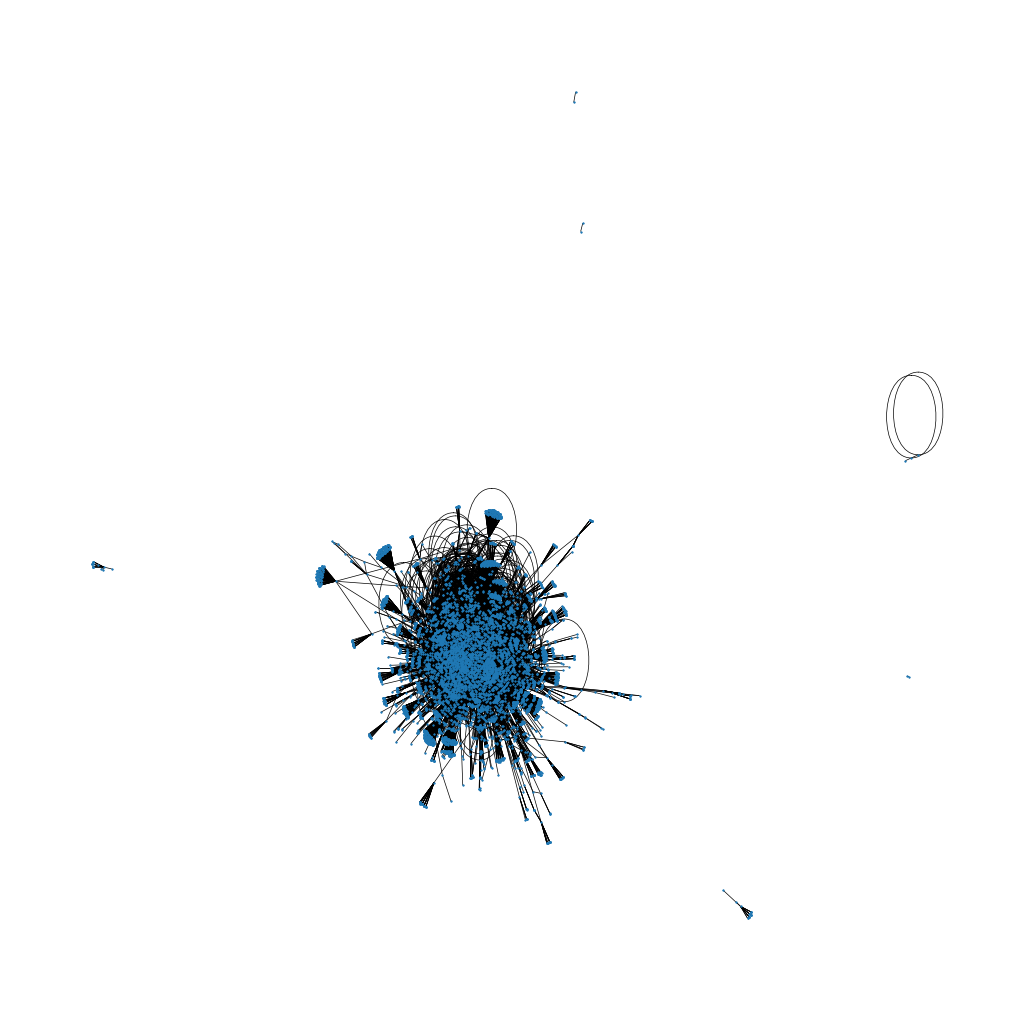

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

for entity in entities:
    G.add_node(entity)
for triplet in triplets:
    G.add_edge(triplet[0], triplet[2], label=triplet[1])

fig = plt.figure(1, figsize=(20, 20), dpi=50)

# Use NetworkX's built-in drawing function to visualize the graph
nx.draw(G, node_size = 5)

# Import matplotlib library to show the graph
plt.show()

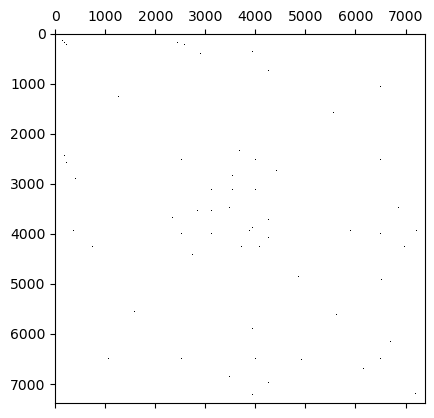

In [22]:
A = nx.to_numpy_matrix(G) #compute the adjacency matrix
plt.spy(A)

In [23]:
nx.is_connected(G)

False

In [24]:
nx.number_connected_components(G)

7

In [25]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [26]:
for subgraph in S:
    print(subgraph.size())

15869
19
17
4
1
1
1


In [27]:
giant_component = S[0]
giant_component.size()

15869

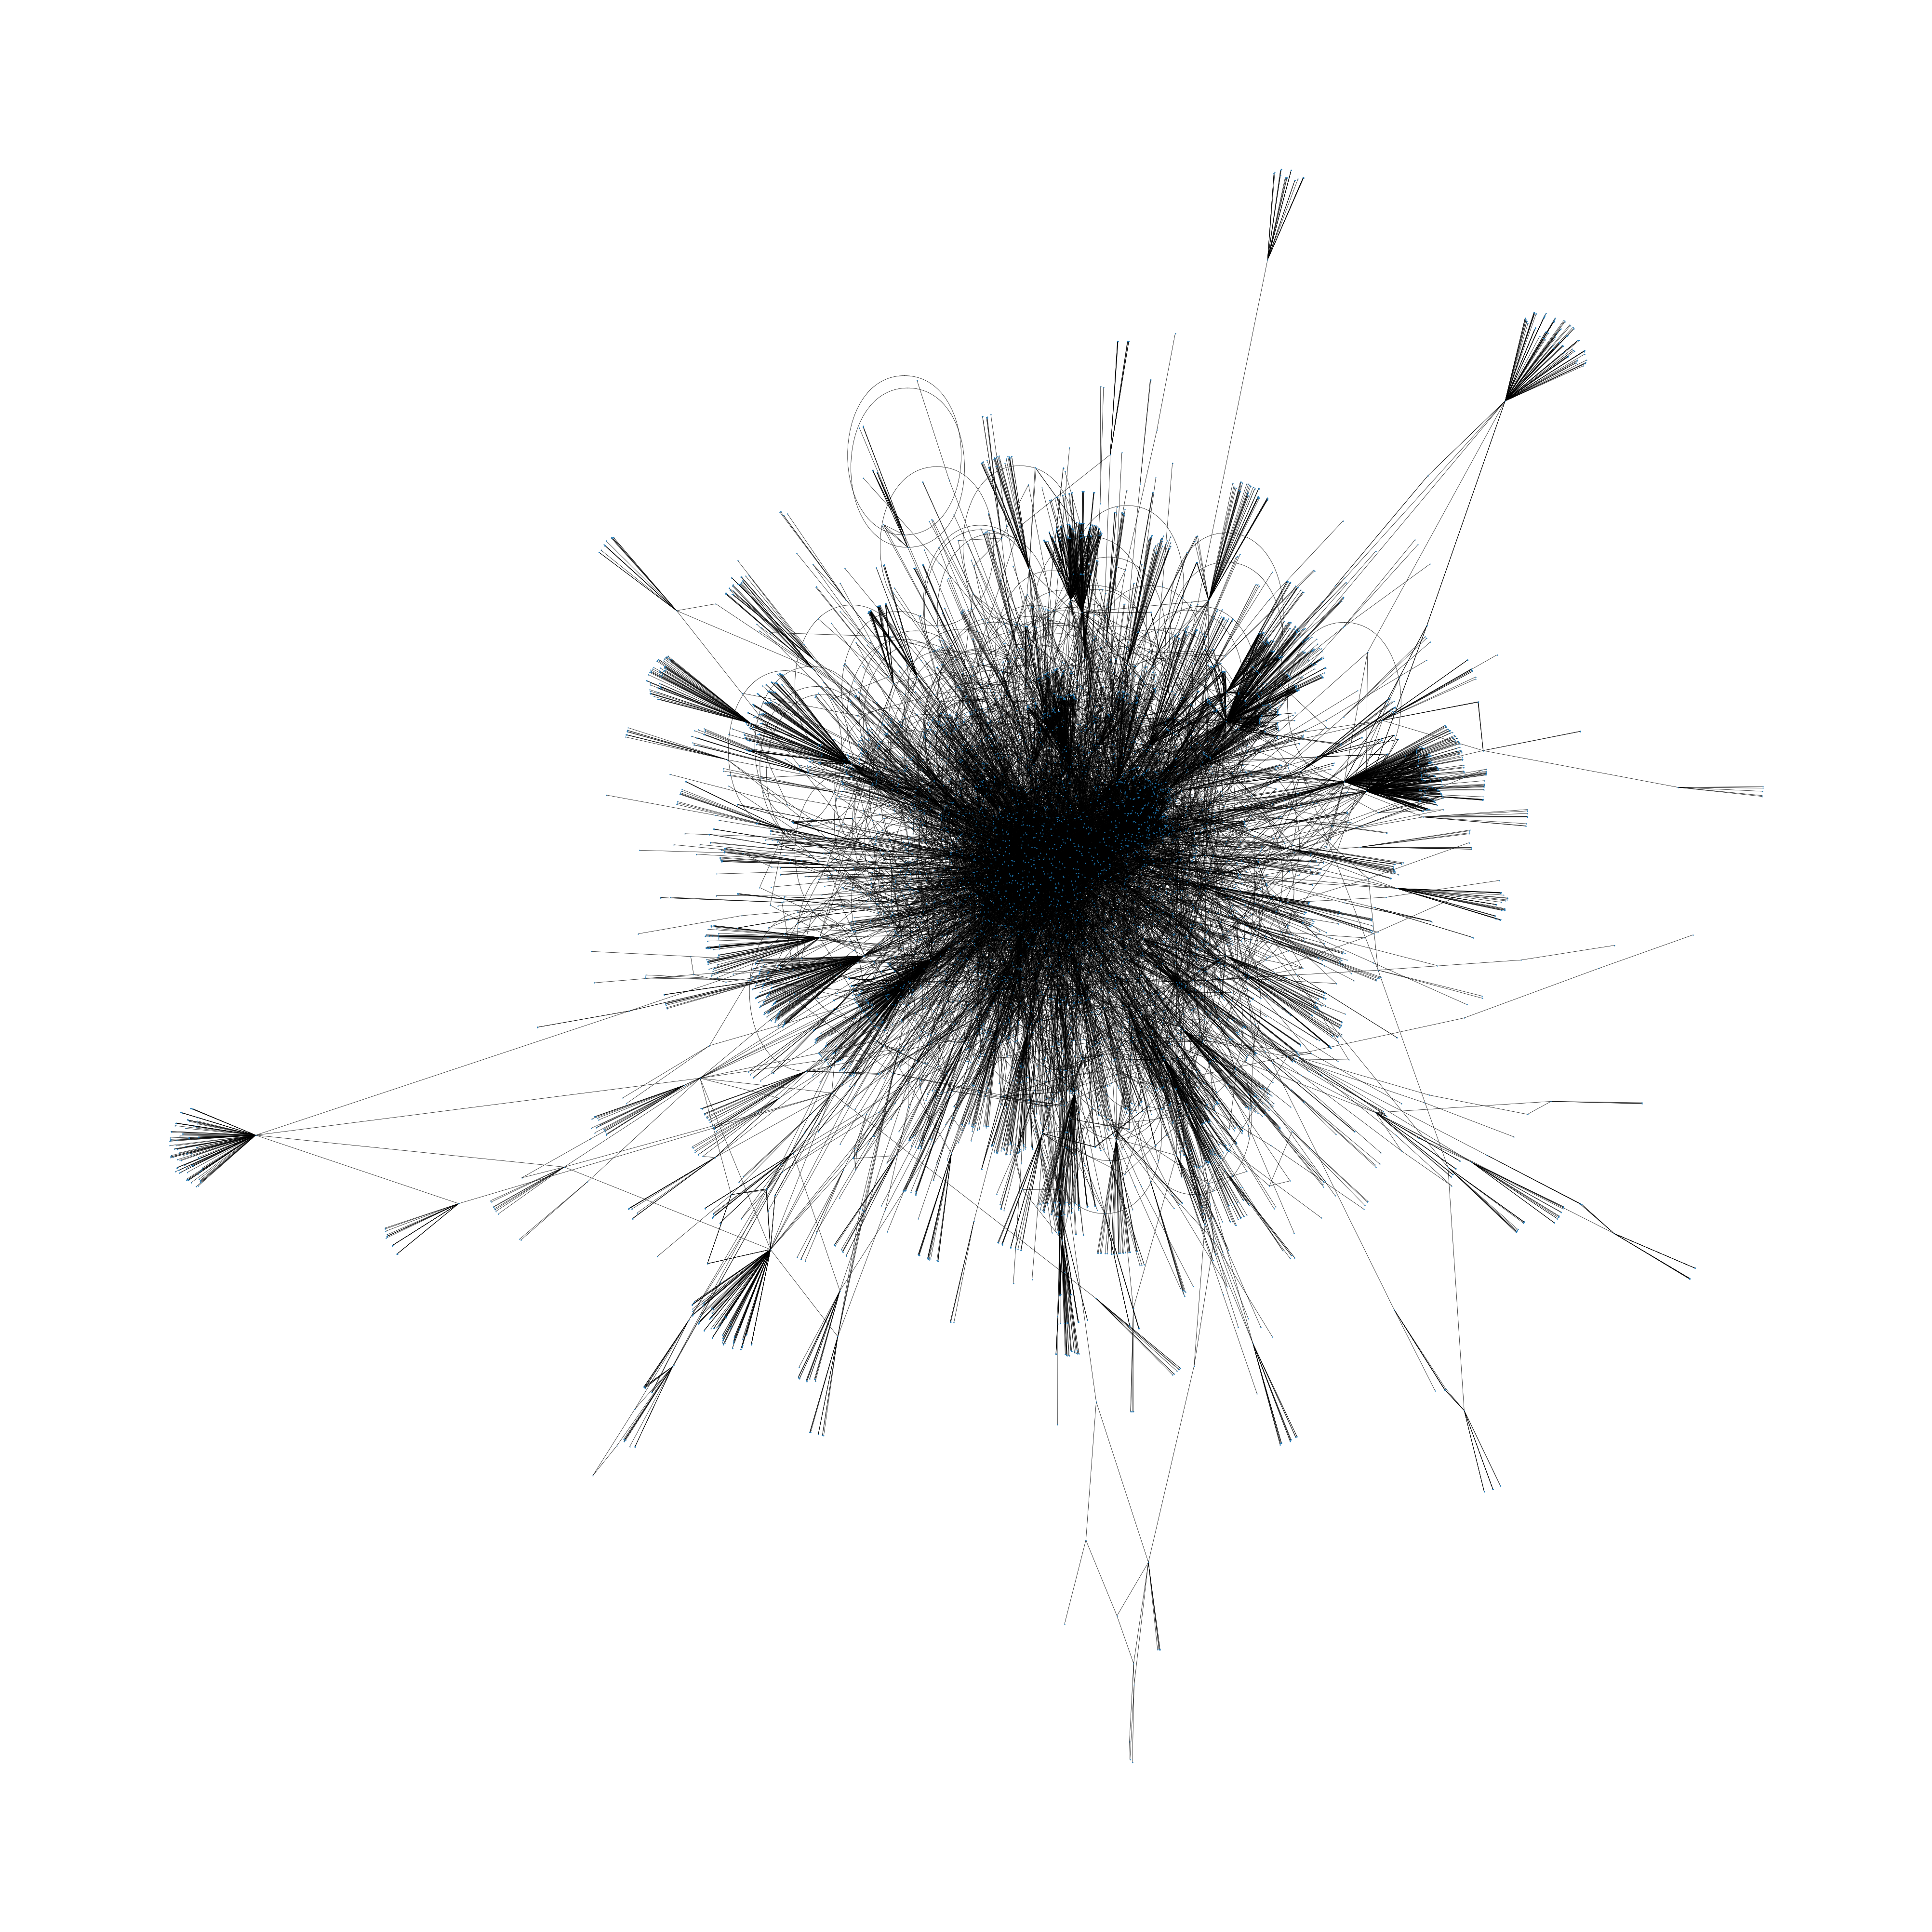

In [28]:
G = giant_component
fig = plt.figure(1, figsize=(80, 80), dpi=50)

# Use NetworkX's built-in drawing function to visualize the graph
nx.draw(G, node_size = 5)

# Import matplotlib library to show the graph
plt.show()

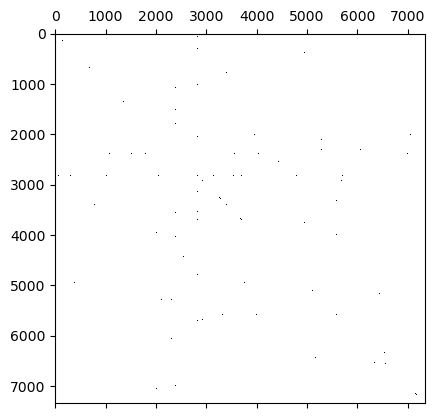

In [29]:
A = nx.to_numpy_matrix(G) #compute the adjacency matrix
plt.spy(A)

In [30]:
def draw_tree_graph_hierarchical(triplets,root):
    print("total triplets: ",len(triplets))
    inserted_triplets = set()
    from anytree import Node, RenderTree
    treeDict = {}
    rootNode = Node(root)
    treeDict[root] = rootNode

    i = 0
    while len(triplets)>0 and i<len(triplets):
        try:
            tempNode = treeDict[triplets[i][2]]
            newNode = Node(triplets[i][0],parent = tempNode)
            treeDict[triplets[i][0]] = newNode
            removed_elem = tuple(triplets.pop(i))
            inserted_triplets.add(removed_elem)
            i = 0
        except:
            i +=1
    print("Left elements: ", len(triplets))
    from anytree.exporter import DotExporter
#     for pre, fill, node in RenderTree(rootNode):
#         print("%s%s" % (pre, node.name))
    from anytree import LevelOrderGroupIter
    level_list = [[node.name for node in children] for children in LevelOrderGroupIter(rootNode, stop=lambda n: n == None)]
#     print(level_list)
    import networkx as nx
    import matplotlib.pyplot as plt

    # Create a graph object
    G = nx.Graph()
    for i in range(len(level_list)):
        for j in range(len(level_list[i])):
            G.add_node(level_list[i][j],layer = i)

    for triplet in inserted_triplets:
        G.add_edge(triplet[0], triplet[2], label=triplet[1])

    node_size = 30
    # Use NetworkX's built-in drawing function to visualize the graph
    # nx.draw(G)
    pos = nx.multipartite_layout(G,subset_key="layer")
    nx.draw_networkx_edges(G,pos,arrowstyle="-|>",arrowsize=10,width=1,arrows=True,node_size=node_size)
    nx.draw_networkx_nodes(G,pos,node_size = node_size)

    # Import matplotlib library to show the graph
    plt.show()

In [31]:
df = tempdf
df=df.drop(['Unnamed: 0','timestamp','rpcid','interface','rt',],axis=1)
df = df.replace('(?)', np.NaN)
df = df.replace('', np.NaN)
df = df.replace('NAN', np.NaN)
df = df.dropna()
df = df.drop_duplicates()
df.nunique()

traceid    130506
um           1474
rpctype         6
dm           7326
dtype: int64

total triplets:  7
Left elements:  0


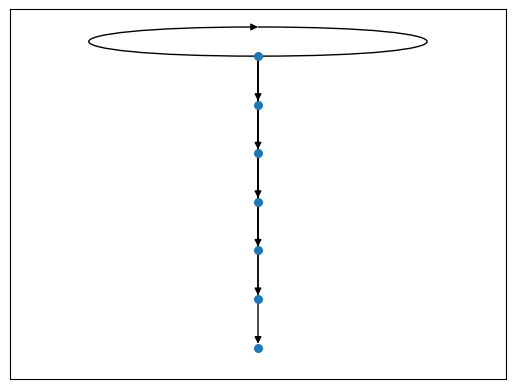

total triplets:  24
Left elements:  9


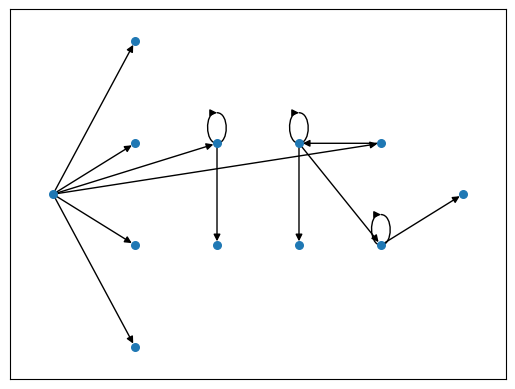

total triplets:  3
Left elements:  0


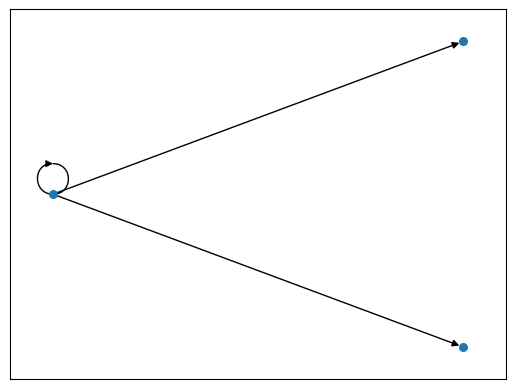

total triplets:  16
Left elements:  0


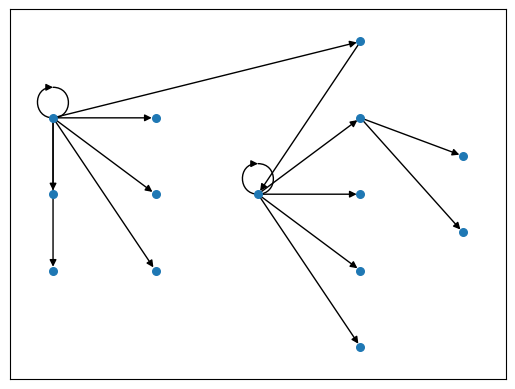

total triplets:  3
Left elements:  0


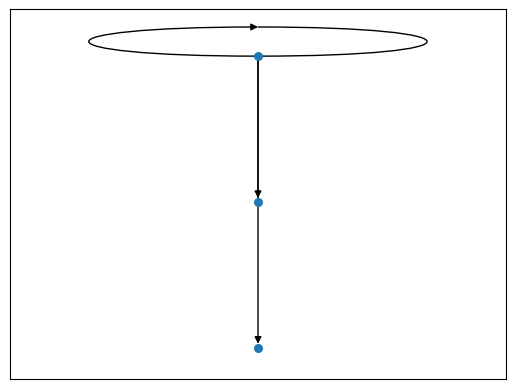

total triplets:  33
Left elements:  7


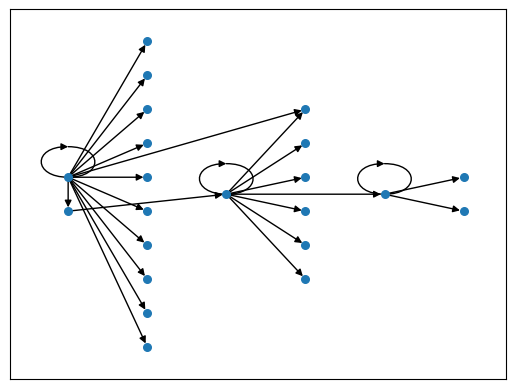

total triplets:  9
Left elements:  0


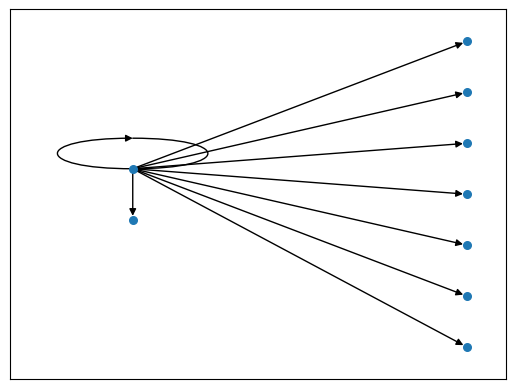

total triplets:  6
Left elements:  0


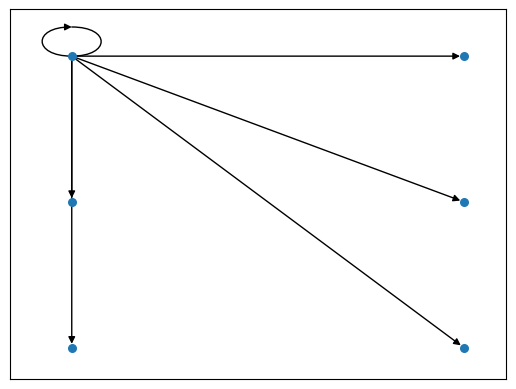

total triplets:  10
Left elements:  3


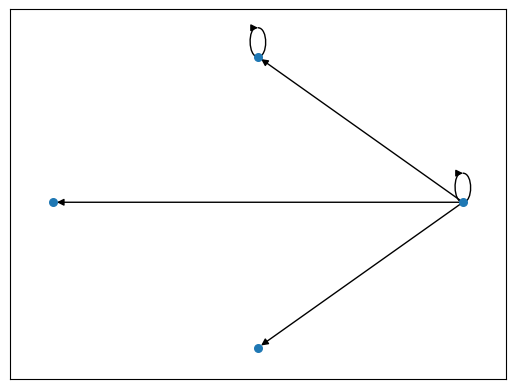

total triplets:  20
Left elements:  0


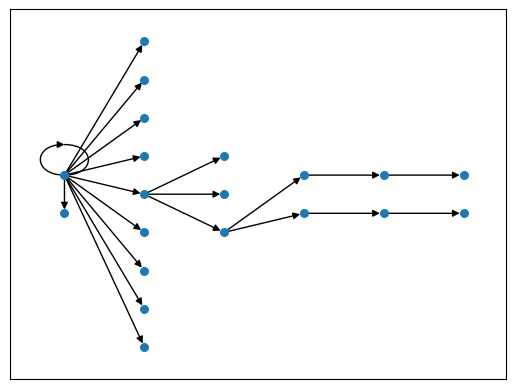

In [32]:
traces = list(set(df['traceid']))
for i in range(10):
    df2 = df[df['traceid'] == traces[i]]
    triplets = []
    entities = set()
    relations = set()
    for i in range(len(df2)):
        head = df2.iloc[i]['dm']
        tail = df2.iloc[i]['um']
        rel = df2.iloc[i]['rpctype']
        entities.add(head)
        entities.add(tail)
        relations.add(rel)
        triplets.append([head,rel,tail])
        
    # Create a graph object
    G = nx.Graph()

    for entity in entities:
        G.add_node(entity)
    for triplet in triplets:
        G.add_edge(triplet[0], triplet[2], label=triplet[1])
        
    T = nx.maximum_spanning_tree(G)

    # Determine the root node
    root = max(T.nodes(), key=lambda n: T.degree(n))
    draw_tree_graph_hierarchical(triplets,root)

In [33]:
df

traceid  \
0        0b133c1915919238193454000e5d37   
11       0b133c1915919238193454000e5d37   
20       0b133c1915919238193454000e5d37   
26       0b133c1915919238193454000e5d37   
42       0b133c1915919238193454000e5d37   
...                                 ...   
6088821  0b52069415919238409694000ea18b   
6088829      015101cf15919238987695000e   
6088839  0b52069415919238409694000ea18b   
6088842  0b52069415919238409694000ea18b   
6088845  0b52069415919237741588000ea044   

                                                        um      rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...           mc   
11       4ab265f54516248ee8873be7d6441912456ce17e84f399...           mc   
20       5cca70246befb1f4c9546d2912b9419dee54439218efa5...  userDefined   
26       75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...          rpc   
42       4ab265f54516248ee8873be7d6441912456ce17e84f399...           mc   
...                                                    ...          ...   
6088821  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...          rpc   
6088829  35114acfb54c54fb9618f23cd28bbc57c765f597df1409...           mc   
6088839  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...           mc   
6088842  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...          rpc   
6088845  95a6f7f8345e2eca31ee74ddc19d547e7fc0f5c8e65772...           mc   

                                                        dm  
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
11       fd6d86bd0fd550e717c1fdb82a33190a9fef216d87d535...  
20       5cca70246befb1f4c9546d2912b9419dee54439218efa5...  
26       84f9f68ef003a21288fffe8f9a09a5a29b05f4cc4229b8...  
42       01d660afcfadafd587e20ec4c04ddbc7eb0de95643ba0e...  
...                                                    ...  
6088821  0d4e0aa3996cbc207424a87d8ce16610b7694e2fac37d7...  
6088829  9653f5baba69c9fb50bfb30a8571eb04dbceaae7c7f379...  
6088839  4bba5c2371c3384862e69615979c2aa5b7f1b4fc3ea914...  
6088842  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088845  9653f5baba69c9fb50bfb30a8571eb04dbceaae7c7f379...  

[1637088 rows x 4 columns]

In [34]:
traces = list(set(df['traceid']))
unique_trace_ids = []
triplets_df = df.drop(['traceid'], axis = 1)
triplets_df = triplets_df.drop_duplicates()
triplets_df

um      rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...           mc   
11       4ab265f54516248ee8873be7d6441912456ce17e84f399...           mc   
20       5cca70246befb1f4c9546d2912b9419dee54439218efa5...  userDefined   
26       75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...          rpc   
42       4ab265f54516248ee8873be7d6441912456ce17e84f399...           mc   
...                                                    ...          ...   
6081607  0674d4c8b48f44a836019adff9dffe0cce2ee6e7b93ee0...           db   
6081615  1cf86b19c487cc10ea3bb9623a319454029e040d0f4e9d...           db   
6081625  2c52c868f36f3920d201fddda80c8062998ebc07ee2b85...           db   
6081642  1cf86b19c487cc10ea3bb9623a319454029e040d0f4e9d...           db   
6084792  5cca70246befb1f4c9546d2912b9419dee54439218efa5...           db   

                                                        dm  
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
11       fd6d86bd0fd550e717c1fdb82a33190a9fef216d87d535...  
20       5cca70246befb1f4c9546d2912b9419dee54439218efa5...  
26       84f9f68ef003a21288fffe8f9a09a5a29b05f4cc4229b8...  
42       01d660afcfadafd587e20ec4c04ddbc7eb0de95643ba0e...  
...                                                    ...  
6081607  039ff41dc3636105ffd26b0ec675eec246a965e8102c77...  
6081615  bb61ac88608568ac2017c8559c1da973f4f94c7d1a958e...  
6081625  abb42d7303a4376befc681f9b4a765c6b6575de0df98ed...  
6081642  b0748973546ca26a9cbfe7802e52924291a76929a704a4...  
6084792  31a97907aa00a2d2d1445a5104bbcc47d70fa52a2370b8...  

[16221 rows x 3 columns]

In [35]:
filtered_df = df.loc[triplets_df.index]
filtered_df

traceid  \
0        0b133c1915919238193454000e5d37   
11       0b133c1915919238193454000e5d37   
20       0b133c1915919238193454000e5d37   
26       0b133c1915919238193454000e5d37   
42       0b133c1915919238193454000e5d37   
...                                 ...   
6081607  0b5218f915919236934722000ec49b   
6081615  0b5218f915919236934722000ec49b   
6081625  0b5218f915919236934722000ec49b   
6081642  0b5218f915919236934722000ec49b   
6084792  0b5206ee15919238244104000e81de   

                                                        um      rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...           mc   
11       4ab265f54516248ee8873be7d6441912456ce17e84f399...           mc   
20       5cca70246befb1f4c9546d2912b9419dee54439218efa5...  userDefined   
26       75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...          rpc   
42       4ab265f54516248ee8873be7d6441912456ce17e84f399...           mc   
...                                                    ...          ...   
6081607  0674d4c8b48f44a836019adff9dffe0cce2ee6e7b93ee0...           db   
6081615  1cf86b19c487cc10ea3bb9623a319454029e040d0f4e9d...           db   
6081625  2c52c868f36f3920d201fddda80c8062998ebc07ee2b85...           db   
6081642  1cf86b19c487cc10ea3bb9623a319454029e040d0f4e9d...           db   
6084792  5cca70246befb1f4c9546d2912b9419dee54439218efa5...           db   

                                                        dm  
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
11       fd6d86bd0fd550e717c1fdb82a33190a9fef216d87d535...  
20       5cca70246befb1f4c9546d2912b9419dee54439218efa5...  
26       84f9f68ef003a21288fffe8f9a09a5a29b05f4cc4229b8...  
42       01d660afcfadafd587e20ec4c04ddbc7eb0de95643ba0e...  
...                                                    ...  
6081607  039ff41dc3636105ffd26b0ec675eec246a965e8102c77...  
6081615  bb61ac88608568ac2017c8559c1da973f4f94c7d1a958e...  
6081625  abb42d7303a4376befc681f9b4a765c6b6575de0df98ed...  
6081642  b0748973546ca26a9cbfe7802e52924291a76929a704a4...  
6084792  31a97907aa00a2d2d1445a5104bbcc47d70fa52a2370b8...  

[16221 rows x 4 columns]

In [36]:
filtered_traces =list(set(filtered_df['traceid']))
len(filtered_traces) # theoretical maximum nuber of unique traces

4362

In [37]:
i = 0
import time
import IPython
tot_n_traces = len(filtered_traces)
tot_n_triplets = len(triplets_df)
start = time.time()
for trace in filtered_traces:
    trace_calls_df = df[df['traceid'] == trace]
    trace_calls_df = trace_calls_df.drop(['traceid'],axis = 1)
    trace_calls_df = trace_calls_df.drop_duplicates()
    
    intersection_df = pd.merge(triplets_df, trace_calls_df)
    if len(intersection_df) > 0:
        unique_trace_ids.append(trace)
        # intersection is a subset of triplets
        triplets_df = pd.concat([triplets_df,intersection_df]).drop_duplicates(keep=False)
    
    remaining_triplets = len(triplets_df)
    if remaining_triplets == 0:
        break
    
    i = i+1
    duration = time.time() - start
    remaining_time = duration/(i/tot_n_traces) - duration
    print("% traces completed: ", (i/tot_n_traces) * 100)
    print("Traces remaining time (s): ", remaining_time)
    print("Traces remaining time (m): ", remaining_time/60)
    print("Traces remaining time (h): ", remaining_time/60/60)
    print("Traces remaining time (d): ", remaining_time/60/60/24)
    
    remaining_time_triplets = duration/(1-(remaining_triplets/tot_n_triplets)) - duration
    print("Remaining triplets: ", remaining_triplets)
    print("% triplets completed: ", (1-(remaining_triplets/tot_n_triplets)) *100)
    print("Triplets remaining time (s): ", remaining_time_triplets)
    print("Triplets remaining time (m): ", remaining_time_triplets/60)
    print("Triplets remaining time (h): ", remaining_time_triplets/60/60)
    print("Triplets remaining time (d): ", remaining_time_triplets/60/60/24)
    IPython.display.clear_output(wait = True)

% traces completed:  99.97707473635947
Traces remaining time (s):  0.11415601552994303
Traces remaining time (m):  0.0019026002588323839
Traces remaining time (h):  3.1710004313873063e-05
Traces remaining time (d):  1.321250179744711e-06
Remaining triplets:  1
% triplets completed:  99.99383515196351
Triplets remaining time (s):  0.030692625383835548
Triplets remaining time (m):  0.0005115437563972591
Triplets remaining time (h):  8.525729273287652e-06
Triplets remaining time (d):  3.5523871972031884e-07


In [38]:
duration = time.time() - start
print("Time required (s): ",duration)

Time required (s):  497.95041394233704


In [39]:
print("Number of unique microservice calls: ",len(unique_trace_ids))

Number of unique microservice calls:  3414


In [40]:
unique_calls_df = df[df['traceid'].isin(unique_trace_ids)]
unique_calls_df

traceid  \
720      0b133ac615919238657334000e5bea   
722      0b133ac615919238657334000e5bea   
723      0b133ac615919238657334000e5bea   
725      0b133ac615919238657334000e5bea   
726      0b133ac615919238657334000e5bea   
...                                 ...   
6086386  0b5114df15919237534872000ef4d4   
6086390  0b5114df15919237534872000ef4d4   
6086391  0b5114df15919237534872000ef4d4   
6086392  0b5114df15919237534872000ef4d4   
6086393  0b5114df15919237534872000ef4d4   

                                                        um      rpctype  \
720      cf5f15ad4585ff713e95993380824a1f0fc1d85792f8dd...           db   
722      24601dd8b36f856eb0a4d759866f475bc62cf843ffe092...          rpc   
723      24601dd8b36f856eb0a4d759866f475bc62cf843ffe092...           mc   
725      24601dd8b36f856eb0a4d759866f475bc62cf843ffe092...           mc   
726      cf5f15ad4585ff713e95993380824a1f0fc1d85792f8dd...           mc   
...                                                    ...          ...   
6086386  d2c895bd5c7de55f381310fd1b94ce9d518bf4ac22e22f...  userDefined   
6086390  81da45152cce70f229b6fe9abdf8e303a5ec88da52bf60...           mq   
6086391  81da45152cce70f229b6fe9abdf8e303a5ec88da52bf60...           mq   
6086392  81da45152cce70f229b6fe9abdf8e303a5ec88da52bf60...           mq   
6086393  90c357ca77801f0d38c1f4cffa2e3d51ef7b1fca91ae35...          rpc   

                                                        dm  
720      5700cc882aab89480dccc110ca8ecb29bee1916f0e43ff...  
722      cf5f15ad4585ff713e95993380824a1f0fc1d85792f8dd...  
723      b6f3db05762621187bfb5833d32b56d90a19c9b688ba5f...  
725      59a9609bcbd8bbf7995db3c435f3d7b6e93923a7a6011b...  
726      37f21f15ffa85dac57941b020a993d3c4682a71ea577a2...  
...                                                    ...  
6086386  d2c895bd5c7de55f381310fd1b94ce9d518bf4ac22e22f...  
6086390  1efeaa8c6ee7899fecd33c8b0ed024154adcc03c7899c1...  
6086391  afd45c934f07a26cb051f0dcaba4934fed1612f9c8a02d...  
6086392  cdc39ad528339be2ad716f4870ce77a0bc2fe2e02ddbdb...  
6086393  de93367b32ae1873de4c22a944ed1c95cc7d8e082d1ae0...  

[203197 rows x 4 columns]

In [41]:
unique_calls_df = unique_calls_df.drop_duplicates()
unique_calls_df

traceid  \
720      0b133ac615919238657334000e5bea   
722      0b133ac615919238657334000e5bea   
723      0b133ac615919238657334000e5bea   
725      0b133ac615919238657334000e5bea   
726      0b133ac615919238657334000e5bea   
...                                 ...   
6086386  0b5114df15919237534872000ef4d4   
6086390  0b5114df15919237534872000ef4d4   
6086391  0b5114df15919237534872000ef4d4   
6086392  0b5114df15919237534872000ef4d4   
6086393  0b5114df15919237534872000ef4d4   

                                                        um      rpctype  \
720      cf5f15ad4585ff713e95993380824a1f0fc1d85792f8dd...           db   
722      24601dd8b36f856eb0a4d759866f475bc62cf843ffe092...          rpc   
723      24601dd8b36f856eb0a4d759866f475bc62cf843ffe092...           mc   
725      24601dd8b36f856eb0a4d759866f475bc62cf843ffe092...           mc   
726      cf5f15ad4585ff713e95993380824a1f0fc1d85792f8dd...           mc   
...                                                    ...          ...   
6086386  d2c895bd5c7de55f381310fd1b94ce9d518bf4ac22e22f...  userDefined   
6086390  81da45152cce70f229b6fe9abdf8e303a5ec88da52bf60...           mq   
6086391  81da45152cce70f229b6fe9abdf8e303a5ec88da52bf60...           mq   
6086392  81da45152cce70f229b6fe9abdf8e303a5ec88da52bf60...           mq   
6086393  90c357ca77801f0d38c1f4cffa2e3d51ef7b1fca91ae35...          rpc   

                                                        dm  
720      5700cc882aab89480dccc110ca8ecb29bee1916f0e43ff...  
722      cf5f15ad4585ff713e95993380824a1f0fc1d85792f8dd...  
723      b6f3db05762621187bfb5833d32b56d90a19c9b688ba5f...  
725      59a9609bcbd8bbf7995db3c435f3d7b6e93923a7a6011b...  
726      37f21f15ffa85dac57941b020a993d3c4682a71ea577a2...  
...                                                    ...  
6086386  d2c895bd5c7de55f381310fd1b94ce9d518bf4ac22e22f...  
6086390  1efeaa8c6ee7899fecd33c8b0ed024154adcc03c7899c1...  
6086391  afd45c934f07a26cb051f0dcaba4934fed1612f9c8a02d...  
6086392  cdc39ad528339be2ad716f4870ce77a0bc2fe2e02ddbdb...  
6086393  de93367b32ae1873de4c22a944ed1c95cc7d8e082d1ae0...  

[203197 rows x 4 columns]

In [42]:
unique_calls_triplets_df = unique_calls_df.drop(['traceid'],axis = 1)
unique_calls_triplets_df = unique_calls_triplets_df.drop_duplicates()
unique_calls_triplets_df

um rpctype  \
720      cf5f15ad4585ff713e95993380824a1f0fc1d85792f8dd...      db   
722      24601dd8b36f856eb0a4d759866f475bc62cf843ffe092...     rpc   
723      24601dd8b36f856eb0a4d759866f475bc62cf843ffe092...      mc   
725      24601dd8b36f856eb0a4d759866f475bc62cf843ffe092...      mc   
726      cf5f15ad4585ff713e95993380824a1f0fc1d85792f8dd...      mc   
...                                                    ...     ...   
6081607  0674d4c8b48f44a836019adff9dffe0cce2ee6e7b93ee0...      db   
6081615  1cf86b19c487cc10ea3bb9623a319454029e040d0f4e9d...      db   
6081625  2c52c868f36f3920d201fddda80c8062998ebc07ee2b85...      db   
6081642  1cf86b19c487cc10ea3bb9623a319454029e040d0f4e9d...      db   
6084792  5cca70246befb1f4c9546d2912b9419dee54439218efa5...      db   

                                                        dm  
720      5700cc882aab89480dccc110ca8ecb29bee1916f0e43ff...  
722      cf5f15ad4585ff713e95993380824a1f0fc1d85792f8dd...  
723      b6f3db05762621187bfb5833d32b56d90a19c9b688ba5f...  
725      59a9609bcbd8bbf7995db3c435f3d7b6e93923a7a6011b...  
726      37f21f15ffa85dac57941b020a993d3c4682a71ea577a2...  
...                                                    ...  
6081607  039ff41dc3636105ffd26b0ec675eec246a965e8102c77...  
6081615  bb61ac88608568ac2017c8559c1da973f4f94c7d1a958e...  
6081625  abb42d7303a4376befc681f9b4a765c6b6575de0df98ed...  
6081642  b0748973546ca26a9cbfe7802e52924291a76929a704a4...  
6084792  31a97907aa00a2d2d1445a5104bbcc47d70fa52a2370b8...  

[16221 rows x 3 columns]

Checking that all unique triplets are present

In [43]:
assert len(unique_calls_triplets_df) == len(df.drop(['traceid'], axis = 1).drop_duplicates())